Для инвестирования 5 млн руб. и cтавки купона, равного 20% разработайте внебиржевой опцион “Autocallable” с ежеквартальным купоном и возможностью досрочного автоматического погашения опциона каждые 3 месяца, если на ежеквартальную купонную дату текущая цена бумаги с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance) превышает или равна барьеру отзыва.

Если продукт не был отозван досрочно, и на последнюю купонную дату текущая цена worst of превышает или равна барьеру поставки, то продукт погашается с выплатой 100% номинала. Иначе, если хотя бы один базовый актив опциона оказался ниже барьера поставки, то осуществляется выплата денежных средств в сумме, равной эквиваленту «поставки бумаги», бумаги с наибольшим снижением относительно своей первоначальной стоимости, по ее первоначальной цене.

В корзину включить четыре базовых актива, первоначальную стоимость определить на день, предшествующий дате запуска (100%). Установить барьер отзыва 105%, купонный барьер 98%, барьер поставки 90% в процентах от первоначальной стоимости каждого базового актива корзину.

**Дата запуска:** 27-07-2022.

**Дата погашения:** 25-07-2023.

**Даты ежеквартальных наблюдений:** 25-10-2022, 25-01-2023, 25-04-2023.

1. Определить действия на купонные даты (выплачивается купон; выплачивается купон с досрочным погашением продукта; не выплачивается, но запоминается; выплачивается купон за текущий и предыдущие кварталы; производится погашение продукта с «эффектом поставки»).
1. Вычислить финансовый результат по состоянию на 25-04-2023,
определить бумагу с наибольшим снижением относительно своей первоначальной стоимости.
1. Привести иллюстративные графики, на которых отобразить бумагу с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance), купонные даты и действия в эти даты, уровни барьеров отзыва, поставки и купонного барьера, первоначальную стоимость актива,
провести исследование влияния уровней барьеров (барьер отзыва, купонный барьер, барьер поставки) на финансовый результат.
1. Повторить расчеты для метода оценки базовых активов -- средневзвешенная динамика стоимости всех активов (average-of perfomance).

[Примеры графиков и расчетов.](https://www.open-broker.com/files/Presentation_OTC-Option_Autocallable_.pdf)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

[*********************100%%**********************]  4 of 4 completed


Действия на купонные даты:
2022-10-25: Выплата купона.
2023-01-25: Купон пропущен.
2023-04-25: Купон пропущен.
2023-07-25: Погашение номинала.

Финансовый результат на 25-04-2023: 4466945.47 руб.


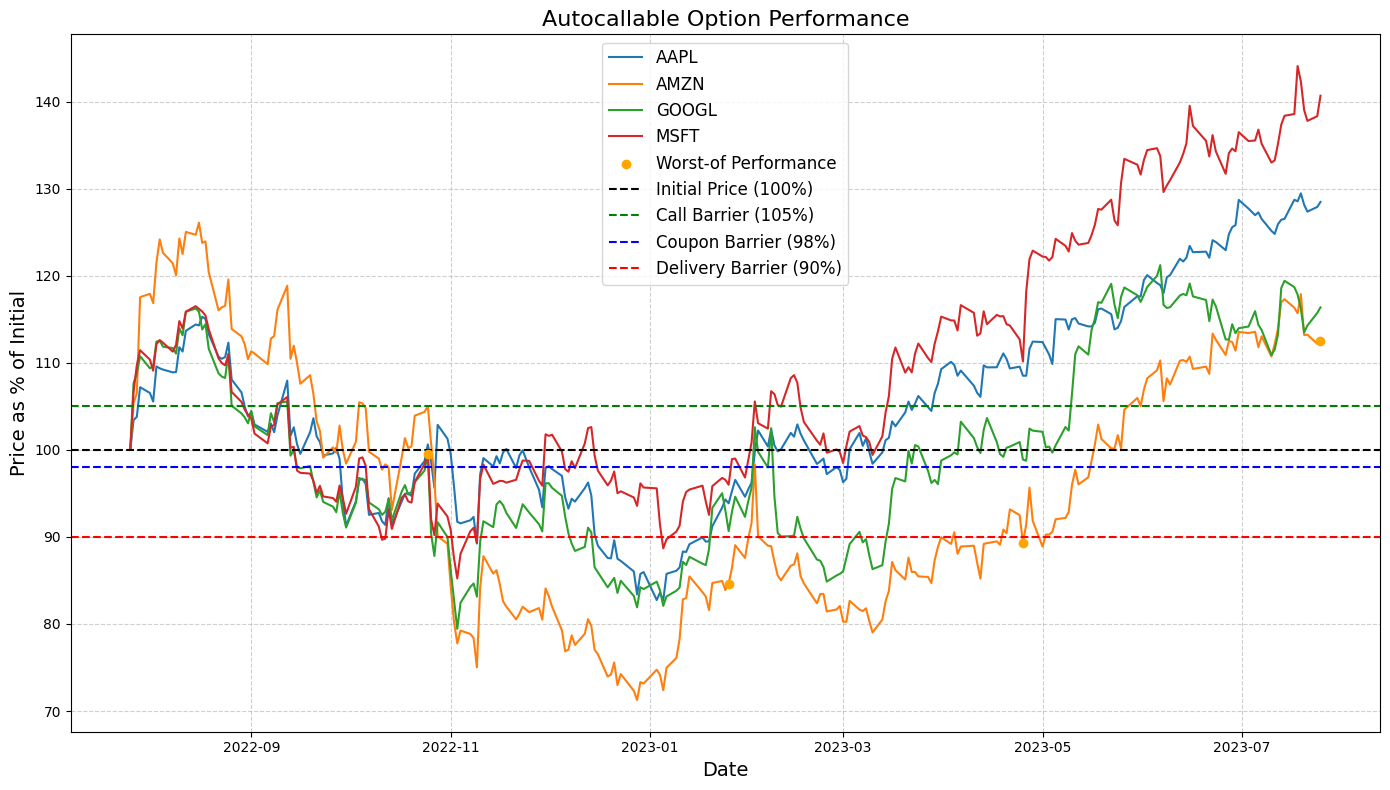

In [7]:
# Параметры задачи
investment = 5_000_000  # Инвестиции (руб)
coupon_rate = 0.20  # Ставка купона (20% годовых)
barrier_call = 1.05  # Барьер отзыва (105%)
barrier_coupon = 0.98  # Купонный барьер (98%)
barrier_delivery = 0.90  # Барьер поставки (90%)

# Тикеры активов
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"]
start_date = "2022-07-26"
end_date = "2023-07-26"
observation_dates = ["2022-10-25", "2023-01-25", "2023-04-25", "2023-07-25"]

# Загрузка данных
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
initial_prices = data.loc["2022-07-26"]
all_normalized_prices = (data / initial_prices) * 100

# Расчет worst-of performance
all_normalized_prices["Worst_of"] = all_normalized_prices.min(axis=1)
observed_data = all_normalized_prices.loc[observation_dates]

# Определение действий на купонные даты
actions = []
for date in observation_dates[:-1]:  # Exclude maturity
    worst_of = observed_data.loc[date, "Worst_of"] / 100
    if worst_of >= barrier_call:
        actions.append(f"{date}: Купон и досрочное погашение.")
        break
    elif worst_of >= barrier_coupon:
        actions.append(f"{date}: Выплата купона.")
    else:
        actions.append(f"{date}: Купон пропущен.")

# Финальная дата
worst_of_final = observed_data.loc[observation_dates[-1], "Worst_of"] / 100
if worst_of_final >= barrier_delivery:
    actions.append(f"{observation_dates[-1]}: Погашение номинала.")
else:
    worst_asset = observed_data.loc[observation_dates[-1]].idxmin()
    actions.append(f"{observation_dates[-1]}: Поставка {worst_asset}.")

# Финансовый результат на 25-04-2023
financial_result = observed_data.loc["2023-04-25", "Worst_of"] * investment / 100

# Результаты
print("Действия на купонные даты:")
for action in actions:
    print(action)

print(f"\nФинансовый результат на 25-04-2023: {financial_result:.2f} руб.")

# График
plt.figure(figsize=(14, 8))
for column in all_normalized_prices.columns[:-1]:  # Exclude 'Worst_of'
    plt.plot(all_normalized_prices.index, all_normalized_prices[column], label=column)

plt.scatter(observation_dates, observed_data["Worst_of"], color="orange", label="Worst-of Performance", zorder=5)
plt.axhline(100, color='black', linestyle='--', label='Initial Price (100%)')
plt.axhline(barrier_call * 100, color='green', linestyle='--', label='Call Barrier (105%)')
plt.axhline(barrier_coupon * 100, color='blue', linestyle='--', label='Coupon Barrier (98%)')
plt.axhline(barrier_delivery * 100, color='red', linestyle='--', label='Delivery Barrier (90%)')

plt.title("Autocallable Option Performance", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price as % of Initial", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()